In [2]:
from structs.fanworks import FicLibrary
from scrapers.ao3 import fic_fields, to_list, load_works
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
plt.style.use("gruvbox.mplstyle")
ofmd=FicLibrary.from_dataframe(load_works("Our Flag Means Death (TV)"))


## Popular Tags and Fic Popularity

In [18]:
ofmd["hits"]=ofmd["hits"].apply(lambda x: 0 if x=="" else float(x))
ofmd["kudos"]=ofmd["kudos"].apply(lambda x: 0 if x=="" else float(x))
ofmd["approval"]=ofmd["kudos"]/ofmd["hits"]

In [28]:
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  0.0702668295490384
The rmse is:  3806.5104632379603


In [ ]:
v=np.array(data["rating"])

In [ ]:
v.reshape(-1,1)

array([['Teen And Up Audiences'],
       ['Teen And Up Audiences'],
       ['General Audiences'],
       ...,
       ['General Audiences'],
       ['Teen And Up Audiences'],
       ['General Audiences']], dtype=object)

In [ ]:
a=OneHotEncoder()

In [ ]:
tf=a.fit_transform(v.reshape(-1,1))

In [ ]:
X=tf
y=ofmd["hits"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.7)

In [ ]:
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [ ]:
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  0.034556355840471786
The rmse is:  4089.7194169457507


In [53]:
ts={t:tags[t].value_counts()[1.0] for t in tags.columns}

In [54]:
f=pd.DataFrame.from_records([ {"tag": t[0], "count": t[1]} for t in ts.items()])

In [60]:
d=f.sort_values(by="count", ascending=False).to_dict(orient="records")

In [61]:
data["hits"]=data["hits"].map(lambda x: float(x) if x !="" else 0)
data["kudos"]=data["kudos"].map(lambda x: float(x) if x !="" else 0)


In [62]:
for rec in d:
    rec["avg_hits"]=data[data[rec["tag"]]==1.0]["hits"].sum()/rec["count"]
    rec["avg_kudos"]=data[data[rec["tag"]]==1.0]["kudos"].sum()/rec["count"]

In [65]:
avg_hits=data["hits"].sum()/len(data)
avg_kudos=data["kudos"].sum()/len(data)

In [66]:
tags=[a["tag"] for a in d]

In [40]:
angst=data[data["Angst"]==1.0]

In [71]:
t=[a["tag"] for a in d]
pop=[a['count'] for a in d]
hits=[a['avg_hits'] for a in d]

<BarContainer object of 665 artists>

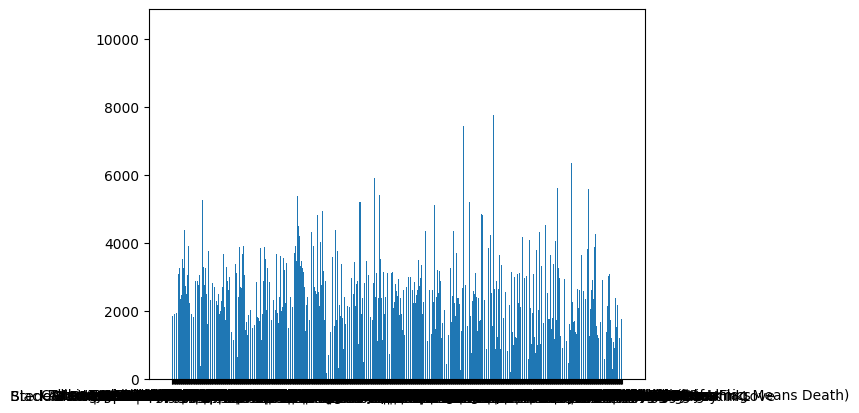

In [73]:
plt.bar(t, hits)

## The Big Model

In [2]:
example=ofmd.iloc[0]
example

title                                                   Lovely Letters
authors                                        [<User [kookaburrito]>]
categories                                                       [M/M]
rating                                           Teen And Up Audiences
warnings                                   [No Archive Warnings Apply]
relationships                 [Blackbeard | Edward Teach/Stede Bonnet]
tags                 [Canon Compliant, Alternate Canon, Letters, Lo...
id                                                            51314557
hits                                                                 4
kudos                                                                 
bookmarks                                                             
complete                                                          True
date_updated                                                2023-11-02
expected_chapters                                                  1.0
nchapt

In [20]:
def simple_model(fics, features, targets):
    for f in features:
        fics[f] = fics[f].apply(lambda x: 0 if x == "" else float(x))
    fics.fillna(value=0.0, inplace=True)
    fics.replace([np.inf, -np.inf], 0.0, inplace=True)
    model = LinearRegression()
    X = fics[targets]
    y = fics[features]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, train_size=0.7
    )
    model.fit(X_train, y_train)
    return model, X_test, y_test

def numberize(fics, column):
    return fics[column].apply(lambda x: 0 if x == "" else float(x))

In [21]:
fics=FicLibrary.from_dataframe(load_works("Our Flag Means Death (TV)"))
features=["kudos", "expected_chapters", "nchapters", "words", "comments"]
target=["hits"]

fics["hits"]=numberize(fics, "hits")
fics["hits"]=np.log(fics["hits"])

model, X_test, y_test=simple_model(fics, features, target)

/home/ehudson/projects/fanficStats/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
plt.hist(np.e**y_pred, bins=100, range=(0,200))
plt.hist(np.e**y_test, alpha=0.5, bins=100, range=(0,200))

## Troubleshooting

In [3]:
def make_numerical(data):
    numeric=["hits", "kudos", "bookmarks", "expected_chapters", "nchapters", "words", "comments"]
    for n in numeric:
        data[n]=data[n].map(lambda x: 0 if x=='' else int(float(x)))

In [3]:
def make_graphs(data):
    targets=[d for d in data.dtypes.to_dict().keys() if data.dtypes[d] == np.dtype("int64")]
    sets=[]
    for t in targets:
        for v in targets:
            rel=set([t, v])
            if (rel not in sets):
                plt.scatter(np.log(data[t]), np.log(data[v]))
                plt.xlabel(t)
                plt.ylabel(v)
                plt.xticks([])
                plt.yticks([])
                plt.savefig(f'./graphs/{t}_{v}')
                plt.show()
                sets.append(rel)
            


In [4]:
def make_log(fics, features):
    for feature in features:
        fics[feature+"_log"]=np.log2(fics[feature])
    fics.replace(to_replace=-np.inf, value=np.float64(-1), inplace=True)

In [5]:
model = LinearRegression()
features=["kudos", "hits", "bookmarks", "expected_chapters", "nchapters", "words", "comments"]
make_numerical(ofmd)
make_log(ofmd, features)


/home/ehudson/projects/fanficStats/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehudson/projects/fanficStats/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehudson/projects/fanficStats/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehudson/projects/fanficStats/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehudson/projects/fanficStats/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)

In [5]:
ofmd.dtypes

title                     object
authors                   object
categories                object
rating                    object
warnings                  object
relationships             object
tags                      object
id                        object
hits                       int64
kudos                      int64
bookmarks                  int64
complete                    bool
date_updated              object
expected_chapters          int64
nchapters                  int64
language                  object
series                    object
summary                   object
fandoms                   object
words                      int64
comments                   int64
kudos_log                float64
hits_log                 float64
bookmarks_log            float64
expected_chapters_log    float64
nchapters_log            float64
words_log                float64
comments_log             float64
dtype: object

In [11]:
y=ofmd[["kudos_log"]]
X=ofmd[["hits", "hits_log", "comments", "comments_log", "nchapters", "nchapters_log"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.7)
model.fit(X_train, y_train)

LinearRegression()

y=kudos
x=hits
m=coefficient
b=intercept (where X is 0, y is...)

In [ ]:
sum(ofmd["kudos_log"])/sum(ofmd["hits_log"])

0.6615669973644743

In [13]:
print(model.coef_, model.intercept_)

[[-8.41962739e-07  8.48837131e-01 -5.80294850e-04  2.44475181e-01
   4.27089506e-03 -4.31387629e-01]] [-2.28326191]


In [12]:
y_pred=model.predict(X_test)
y_pred_df=pd.DataFrame(columns=["kudos_log"], data=y_pred)
y_test_df=pd.DataFrame(columns=["kudos_log"], data=y_test)
r2=r2_score(y_test, y_pred)
rmse=mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse} \n R2: {r2}')


RMSE: 0.41850119525135876 
 R2: 0.899894658686741


In [ ]:
len(y_pred_df), len(y_test_df)

(7407, 7407)

In [ ]:
yp=2**y_pred


In [ ]:
yp

array([[813.18249362],
       [ 39.62361207],
       [ 10.74391595],
       ...,
       [ 64.99132181],
       [ 46.90748655],
       [  7.10398281]])

(array([4.512e+03, 1.360e+03, 5.700e+02, 3.100e+02, 1.930e+02, 1.290e+02,
        7.600e+01, 6.100e+01, 3.900e+01, 3.000e+01, 1.700e+01, 1.700e+01,
        1.300e+01, 1.700e+01, 4.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
        7.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

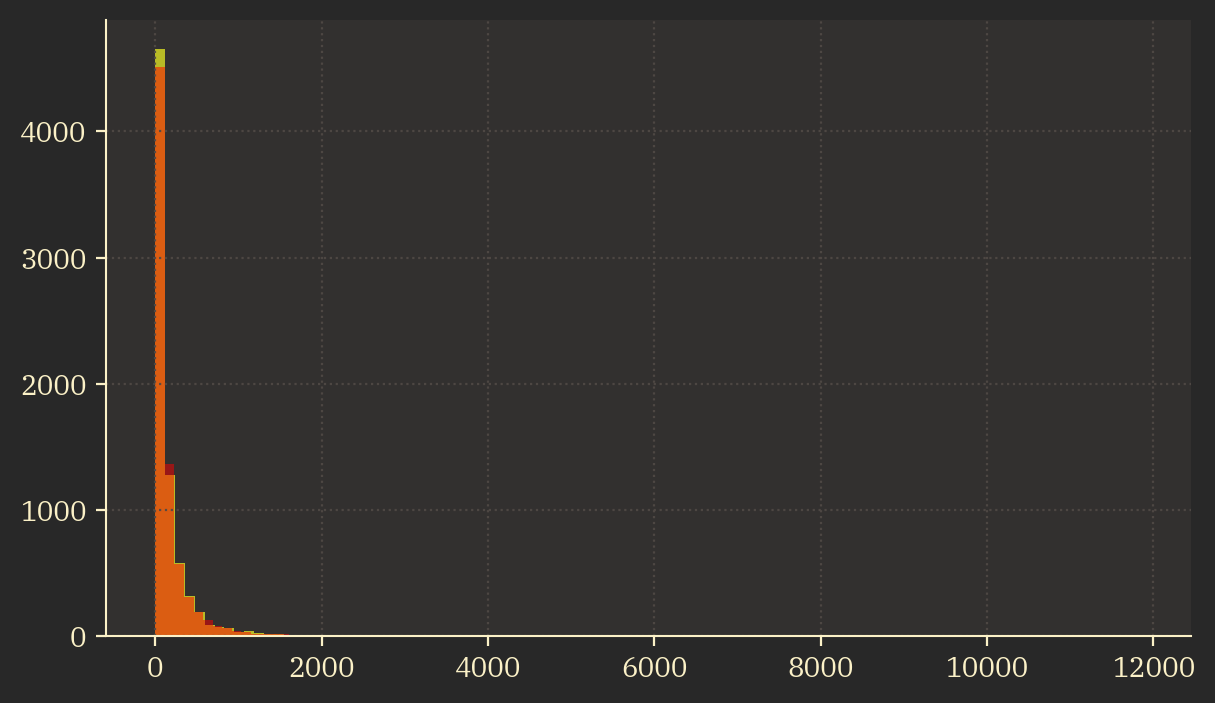

In [14]:
plt.hist(2**y_pred_df['kudos_log'], bins=100)
plt.hist(2**y_test_df['kudos_log'], bins=100, color="red", alpha=0.5)